# Three investigators - part II

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part II: Data preparation and explorative analysis

- additional data cleaning and preparing for analysis
- using [Genderize API](https://github.com/SteelPangolin/genderize) to predict gender of actors using first names
- explorative analysis of data
- prediction of episode ratings

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

3.7.5


In [2]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests
from datetime import date

# for file directories
import os

#change directory to root folder
os.chdir("..")

#load script to work with Genderize API (download [here](https://github.com/SteelPangolin/genderize))
#this will require to have requests imported
from src.genderize import Genderize

%matplotlib inline

# Load data

In [9]:
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
actors = pd.read_csv(".\\data\\scraped\\actor_all.csv")
content = pd.read_csv(".\\data\\scraped\\content_all.csv")
rating = pd.read_csv(".\\data\\scraped\\rating.csv")
gender = pd.read_csv(".\\data\\processed\\actor_gender_prediction_2020-09-26.csv")

In [10]:
meta.shape

(205, 44)

# Data cleaning and prep

## Consistent column labels

In [11]:
# make all column names lower case
df_list = [meta, actors, content, rating]

for df in df_list:
    df.columns = df.columns.str.lower()

## add/remove episode 29 from tables

In [12]:
### add episode 29 details to meta table (https://www.rocky-beach.com/hoerspiel/folgen/029.html)
meta = meta.append({'id' : 29, 'music': 'B. Brac/B. George', 'date':'1982-03-21', 
                     'minutes': 34, 'minutes_mean':34, 'minutes_total':34, 'parts':1} , ignore_index=True)

## remove 29 from actors table
actors = actors.loc[actors["id"] != 29]

In [13]:
meta.loc[meta["id"] == 29]

,id,"""anudhara"" aufgenommen bei bantree records, worms / produzent",buch,buch und effekte,buch und redaktion,cover-illustration,coverillustration,design,effekte und redaktion,erscheinungsdatum,...,cover,music,director,editor,sounds,date,minutes,minutes_mean,minutes_total,parts
205,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,B. Brac/B. George,NaN,NaN,NaN,1982-03-21,34,34.0,34,1


## Predict actors' gender

In [ ]:
##get gender for list of firstnames from Genderize.io
#
##get unique list of first actor names
#names_unique = list (set (actors["firstname"]))
#
##access genderize.io api using this repository: tps://github.com/SteelPangolin/genderize
#gender_raw = Genderize().get(names_unique)
#
##make dictionary into data frame
#gender = []
#for i in range(len(gender_raw)):
#    c = pd.DataFrame(gender_raw[i].items())[1]
#    gender.append(c)
#
##rename columns
#gender = pd.concat(gender, axis=1).transpose().rename(columns={0:"name", 1:"gender", 2:"gender_probability", 3:"gender_count"})  
#
##save output as backup to access later
#gender.to_csv(".\\data\\processed\\actor_gender_prediction_" + "%s" %(str(date.today())) + ".csv") 
#
##display
#gender.head()

In [14]:
# join tables
actors = pd.merge(actors, gender, left_on='firstname', right_on = "name", how="left")
actors = actors.drop("name", axis=1)
actors.head()

,role,actor,id,actor_clean,title,firstname,surename,no_names,main_actor,narrator,Unnamed: 0,gender,gender_probability,gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,1,male,0.99,165452
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,1,male,0.99,32776
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,1,male,0.99,23807
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,1,male,0.99,71365
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,1,male,0.99,101928


In [15]:
# get list of names that have not been classified with a gender
actors.loc[actors["gender"].isna()]["firstname"].unique()

array(['Heikedine', 'Reinhilt', 'J.S.', 'H.', 'Schiffmeister', '...',
       'Rosakutty', 'Gustav-Adolph', 'Rhesi', 'é', 'Jörgpeter'],
      dtype=object)

In [16]:
## classify gender of missing ones (if known)
actors.loc[actors["firstname"] == 'Heikedine', "gender"] = "female"
actors.loc[actors["firstname"] == 'Reinhilt', "gender"] = "female"
actors.loc[actors["firstname"] == 'Gustav-Adolph', "gender"] = "male"
actors.loc[actors["firstname"] == 'Jörgpeter', "gender"] = "male"
actors.loc[actors["firstname"] == 'Rhesi', "gender"] = "female"
actors.loc[actors["firstname"] == 'é', "gender"] = "male"

## Add to meta data

In [17]:
## Create year and month column
meta["year"] = pd.DatetimeIndex(meta["date"]).year
meta["month"] = pd.DatetimeIndex(meta["date"]).month

### Number of actors, main and side

In [19]:
actors_agg = pd.DataFrame(actors.groupby("id")[["actor", "main_actor", "narrator"]].agg(
    {"actor": "count", "main_actor":"sum", "narrator": "max"})).reset_index()
actors_agg = actors_agg.rename(columns={"actor":"no_actors_total", "main_actor":"no_main_actors"})
actors_agg["no_side_actors"] = actors_agg["no_actors_total"] - actors_agg["no_main_actors"] - actors_agg["narrator"] #also remove narrator

#join with meta
meta = pd.merge(meta, actors_agg, left_on="id" ,right_on="id", how='left')

### Gender balance all actors

In [21]:
actors_gender = actors.groupby(["id", "gender"])["role"].count()
actors_gender = pd.DataFrame(actors_gender).unstack().fillna(0).reset_index("id")
actors_gender.columns = actors_gender.columns.droplevel(level=0)
actors_gender = actors_gender.rename(columns={"": "id", "female": "no_female_actors", "male": "no_male_actors"})

#join with meta
meta = pd.merge(meta, actors_gender, left_on="id" ,right_on="id", how='left')

#gender missing
meta["no_actor_gender_missing"] = meta["no_actors_total"] - meta[["no_female_actors", "no_male_actors"]].sum(axis=1)

#gender balance for all actors
meta["female_actors_ratio"] = meta["no_female_actors"] / meta[["no_female_actors", "no_male_actors"]].sum(axis=1) *100

### Gender balance side actors

In [23]:
filter_side_actors = (actors["narrator"] == 0) & (actors["main_actor"] == 0)
side_actors_gender = actors.loc[filter_side_actors].groupby(["id", "gender"])["role"].count()
side_actors_gender = pd.DataFrame(side_actors_gender).unstack().fillna(0).reset_index("id")
side_actors_gender.columns = side_actors_gender.columns.droplevel(level=0)
side_actors_gender = side_actors_gender.rename(columns={"": "id", "female": "no_female_side_actors", "male": "no_male_side_actors"})

#join with meta
meta = pd.merge(meta, side_actors_gender, left_on="id" ,right_on="id", how='left')

#gender balance for side actors
meta["female_side_actors_ratio"] = meta["no_female_side_actors"] / meta[["no_female_side_actors", "no_male_side_actors"]].sum(axis=1) *100

# Explorative Analysis

## Chronology

In [27]:
years = meta.groupby("year")[["parts", "minutes_mean", "id"]].agg({
    "parts": ["sum"], "minutes_mean" : ["mean", "min", "max"], "id": ["count","min", "max"]})
years.columns = ["_".join(x) for x in years.columns.ravel()]
years = years.reset_index().rename(columns={"minutes_mean_mean": "minutes_mean",
                              "minutes_mean_min": "minutes_min", "minutes_mean_max":"minutes_max"}) 
years.head()

,year,parts_sum,minutes_mean,minutes_min,minutes_max,id_count,id_min,id_max
0,1979,9,45.555556,43.0,50.0,9,1,9
1,1980,12,42.416667,38.0,49.0,12,10,21
2,1981,6,43.666667,41.0,49.0,6,22,27
3,1982,3,39.333333,34.0,44.0,3,28,30
4,1983,3,43.666667,40.0,49.0,3,31,33


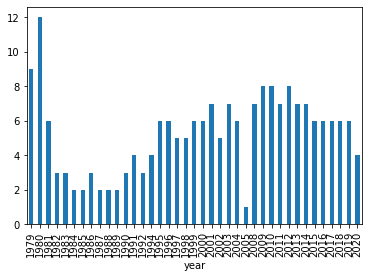

In [28]:
#number of episodes over time
years.set_index("year")["id_count"].plot(kind='bar')

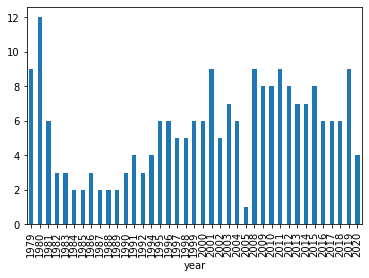

In [29]:
#number of episodes over time
years.set_index("year")["parts_sum"].plot(kind='bar')

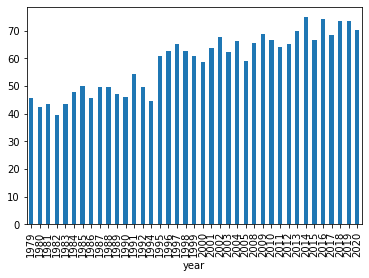

In [30]:
#Average length over time
years.set_index("year")["minutes_mean"].plot(kind='bar')

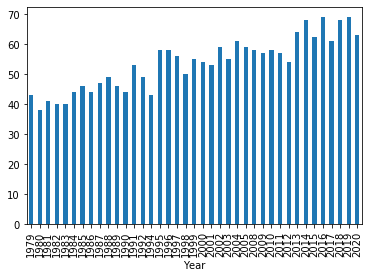

In [29]:
#Average length over time
years.set_index("year")["minutes_min"].plot(kind='bar')

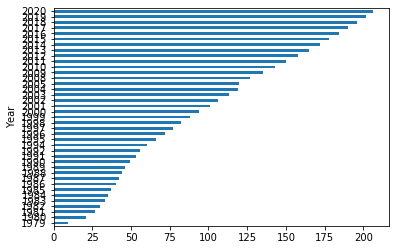

In [37]:
#number of episodes over time
years.set_index("year")["id_max"].plot(kind='barh')

## Gender

In [41]:
## calculate gender roles by episode
no_main = (actors["Narrator"] == 0) & (actors["Main_actor"] == 0)
gender_balance = actors.loc[no_main].groupby(["ID", "Gender"])["Role"].count()
gender_balance = pd.DataFrame(gender_balance).unstack().fillna(0).reset_index("ID")
gender_balance.columns = gender_balance.columns.droplevel(level=0)
gender_balance["total"] = gender_balance[["female", "male"]].sum(axis=1)
gender_balance["female_ratio"] = round(gender_balance["female"] / gender_balance["total"] * 100, 1)
gender_balance = gender_balance.rename(columns={"": "ID"})
gender_balance

Gender,ID,female,male,total,female_ratio
0,1,2.0,6.0,8.0,25.0
1,2,3.0,7.0,10.0,30.0
2,3,1.0,7.0,8.0,12.5
3,4,0.0,11.0,11.0,0.0
4,5,3.0,6.0,9.0,33.3
...,...,...,...,...,...
201,202,2.0,4.0,6.0,33.3
202,203,3.0,3.0,6.0,50.0
203,204,2.0,5.0,7.0,28.6
204,205,5.0,8.0,13.0,38.5


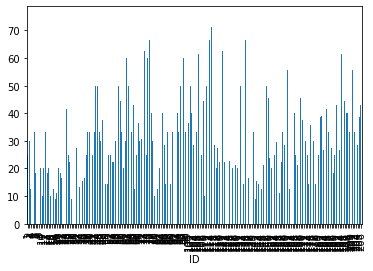

In [42]:
#number of episodes over time
gender_balance.set_index("ID")["female_ratio"].plot(kind='bar')